<a href="https://colab.research.google.com/github/NicoEssi/DD2437_Artificial_Neural_Networks_and_Deep_Architectures/blob/master/Lab2_Part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from math import sqrt
import numpy as np
import pandas as pd
import collections as cl
import matplotlib.pyplot as plt

In [0]:
# Importing the data

# Animal Topology
!wget https://raw.githubusercontent.com/NicoEssi/DD2437_Artificial_Neural_Networks_and_Deep_Architectures/master/data_lab2/animalnames.txt
!wget https://raw.githubusercontent.com/NicoEssi/DD2437_Artificial_Neural_Networks_and_Deep_Architectures/master/data_lab2/animalattributes.txt
!wget https://raw.githubusercontent.com/NicoEssi/DD2437_Artificial_Neural_Networks_and_Deep_Architectures/master/data_lab2/animals.dat

# Swedish Parliament
!wget https://raw.githubusercontent.com/NicoEssi/DD2437_Artificial_Neural_Networks_and_Deep_Architectures/master/data_lab2/votes.dat
!wget https://raw.githubusercontent.com/NicoEssi/DD2437_Artificial_Neural_Networks_and_Deep_Architectures/master/data_lab2/mpsex.dat
!wget https://raw.githubusercontent.com/NicoEssi/DD2437_Artificial_Neural_Networks_and_Deep_Architectures/master/data_lab2/mpparty.dat

In [0]:
class SOM(object):
    def __init__(self, x, y, input_len, sigma = 1.0, learning_rate = 0.5, decay_function = None, random_seed = None):
        """
        Initializes Self Organizing Map.
        x, y - neuron dimensions
        input_len - number of elements of the input vector
        sigma - gaussian spread of the neighborhood
        learning_rate - learning rate
        decay_function - learning rate reduction per iteration
        random_seed - recommended to tune due to nature of SOM
        """
        
        # Random Seed
        if random_seed:
            self.random_generator = np.random.RandomState(random_seed)
        
        self.weights = self.random_generator.rand(x, y, input_len)*2-1
        
        for i in range(x):
            for j in range(y):
                self.weights[i,j] = self.weights[i,j] / (sqrt(np.dot(self.weights[i,j], self.weights[i,j].T)))
        
        # Sigma
        self.sigma = sigma
        
        # Learning Rate
        self.learning_rate = learning_rate
        
        # Decay Function
        if decay_function:
            self._decay_function = decay_function
        else:
            self._decay_function = lambda x, t, max_iter: x/(1+t/max_iter)
        
        # Related to other functions
        self.activation_map = np.zeros((x,y))
        self.neighborx = np.arange(x)
        self.neighbory = np.arange(y)
        self.neighborhood = self.gaussian
         
    def gaussian(self, c, sigma):
        # Ignore; works as it should
        d = 2*np.pi*sigma*sigma
        ax = np.exp(-np.power(self.neighborx-c[0], 2)/d)
        ay = np.exp(-np.power(self.neighbory-c[1], 2)/d)
        return np.outer(ax, ay)
        
    def _activate(self, x):
        # Ignore; works as it should
        subs = np.subtract(x, self.weights) # x - w
        it = np.nditer(self.activation_map, flags=['multi_index'])
        while not it.finished:
            self.activation_map[it.multi_index] = sqrt(np.dot(subs[it.multi_index], subs[it.multi_index].T))
            it.iternext()
    
    def activate(self, x):
        # Ignore; works as it should
        self._activate(x)
        return self.activation_map
    
    def BMU(self, x):
        """
        Returns the best matching unit
        """
        self._activate(x)
        return np.unravel_index(self.activation_map.argmin(), self.activation_map.shape)
    
    def update(self, x, win, t):
        # Ignore; works as it should
        eta = self._decay_function(self.learning_rate, t, self.T)
        sig = self._decay_function(self.sigma, t, self.T)
        g = self.neighborhood(win, sig)*eta
        it = np.nditer(g, flags=['multi_index'])
        while not it.finished:
            self.weights[it.multi_index] += g[it.multi_index]*(x-self.weights[it.multi_index])
            self.weights[it.multi_index] = self.weights[it.multi_index] / (sqrt(np.dot(self.weights[it.multi_index], self.weights[it.multi_index].T)))
            it.iternext()
            
    def init_weights(self, data):
        """
        Initializes the neuron weights
        """
        it = np.nditer(self.activation_map, flags=['multi_index'])
        while not it.finished:
            self.weights[it.multi_index] = data[self.random_generator.randint(len(data))]
            self.weights[it.multi_index] = self.weights[it.multi_index]/ (sqrt(np.dot(self.weights[it.multi_index], self.weights[it.multi_index].T)))
            it.iternext()
            
    def train_random(self, data, num_iteration):
        """
        Train the SOM using vectors randomly
        """
        self.T = num_iteration/2
        for iteration in range(num_iteration):
            rand_i = self.random_generator.randint(len(data)) # pick a random sample
            self.update(data[rand_i], self.BMU(data[rand_i]), iteration)
            
    def train_sequen(self, data, num_iteration):
        """
        Train the SOM using vectors sequentially
        """
        self.T = (len(data)*num_iteration)/2
        iteration = 0
        while iteration < num_iteration:
            idx = iteration % (len(data)-1)
            self.update(data[idx], self.BMU(data[idx]), iteration)
            iteration += 1
            
    def distance_map(self):
        """
        Returns the distance map of the neuron weights
        """
        um = np.zeros((self.weights.shape[0], self.weights.shape[1]))
        it = np.nditer(um, flags=['multi_index'])
        while not it.finished:
            for ii in range(it.multi_index[0]-1, it.multi_index[0]+2):
                for jj in range(it.multi_index[1]-1, it.multi_index[1]+2):
                    if ii >= 0 and ii < self.weights.shape[0] and jj >= 0 and jj < self.weights.shape[1]:
                        um[it.multi_index] += (sqrt(np.dot((self.weights[ii, jj, :]-self.weights[it.multi_index]),(self.weights[ii, jj, :]-self.weights[it.multi_index]).T)))
            it.iternext()
        um = um/um.max()
        return um
    
    def BMU_map(self,data):
        """
        Returns a dictionary with all the mapped patterns :)
        """
        BMUmap = cl.defaultdict(list)
        for x in data:
            BMUmap[self.BMU(x)].append(x)
        return BMUmap

--2020-02-01 22:43:14--  https://raw.githubusercontent.com/NicoEssi/DD2437_Artificial_Neural_Networks_and_Deep_Architectures/master/data_lab2/animalnames.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 346 [text/plain]
Saving to: ‘animalnames.txt.2’

animalnames.txt.2   100%[===================>]     346  --.-KB/s    in 0s      

2020-02-01 22:43:14 (79.9 MB/s) - ‘animalnames.txt.2’ saved [346/346]

--2020-02-01 22:43:15--  https://raw.githubusercontent.com/NicoEssi/DD2437_Artificial_Neural_Networks_and_Deep_Architectures/master/data_lab2/animalattributes.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:4

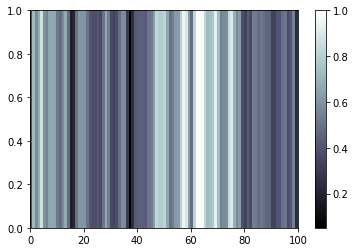

[[0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1.
  1. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
  1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1.
  1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
  1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1.
  1. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1.
  1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]


In [12]:
dfnames = pd.read_table("animalnames.txt", sep="\s+", header=None) #Importing names
dfattr = pd.read_table("animalattributes.txt", header=None) #Importing attributes
dfattr = dfattr.T
df = pd.read_csv("animals.dat", header=None) #Importing data
df = pd.DataFrame(df.values.reshape(-1, 84))
df2 = pd.concat(([df, dfnames]), axis = 1)

# Adding indeces
#df.index = dfnames
#df = df.rename(columns = dfattr.iloc[0])

# Feature Scaling (not actually needed but whatever)
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
df = sc.fit_transform(df)

#Training the SOM
som = SOM(x = 100, y = 1, input_len = 84, sigma = 10.0, learning_rate = 0.2, random_seed = 3)
som.init_weights(df)
som.train_random(data = df, num_iteration = 20)

# Visualize the results
from pylab import bone, pcolor, colorbar, show
bone()
pcolor(som.distance_map().T)
colorbar()
show()

mappings = som.BMU_map(df)
animals = sc.inverse_transform(mappings[(97,0)]) # checking X-coordinate 97
print(animals)

In [24]:
dfpart = pd.read_csv("mpparty.dat", header = None)

dfpart

,0,1,2,3,4,5,6,7
0,% Coding: 0=no party,1='m',2='fp',3='s',4='v',5='mp',6='kd',7='c'
1,% Use some color scheme for these different gr...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,\t 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,\t 1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
346,\t 3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
347,\t 3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
348,\t 3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
349,\t 1,NaN,NaN,NaN,NaN,NaN,NaN,NaN


TypeError: ignored

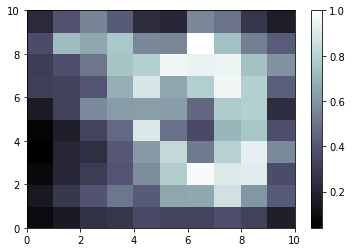

In [16]:
df = pd.read_csv("votes.dat", header=None) #Importing data
df = pd.DataFrame(df.values.reshape(-1, 31))

# Feature Scaling (not actually needed but whatever)
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
df = sc.fit_transform(df)

# Training the SOM
som = SOM(x = 10, y = 10, input_len = 31, sigma = 0.5, learning_rate = 0.3, random_seed = 3)
som.init_weights(df)
som.train_random(data = df, num_iteration = 3000)

# Visualizing the results
from pylab import bone, pcolor, colorbar, plot, show
bone()
pcolor(som.distance_map().T)
colorbar()

# Visualize sexes and parties
sexes = ['x', 'o'] #x for male, o for female
parties = ['#ffffff', 'b', 'b', 'r', 'r', 'g', 'b', 'b'] #categorized by affiliation
dfsex = pd.read_csv("mpsex.dat")
dfsex = dfsex.iloc[:,0]
dfparty = pd.read_csv("mpparty.dat")
dfparty = dfparty.iloc [:,0]
for i, x in enumerate(df):
    w = som.BMU(x)
    plot(w[0] + 0.5,
         w[1] + 0.5,
         sexes[dfsex[i]],
         markeredgecolor = parties[dfparty[i]],
         markerfacecolor = 'None',
         markersize = 10,
         markeredgewidth = 2)
show()